<div align="center" style=" font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/Python-Notebook-Banners/Code_challenge.png"  style="display: block; margin-left: auto; margin-right: auto;";/>
</div>


## Regression MCQ
© ExploreAI Academy

In this MCQ, we will engage in a comprehensive multiple-choice exercise, applying regression concepts and techniques to agricultural yield prediction. Through a series of challenges, we'll analyse variable relationships, feature engineering, model construction, and evaluation, enhancing our understanding and proficiency in regression analysis.

# Learning objectives
By the end of this notebook, you should be able to:

* Analyse predictor variables and their relationship with the target variable.
* Perform feature engineering tasks, including encoding categorical variables and scaling features.
* Construct and evaluate multiple linear regression models using appropriate libraries.
* Identify and address multicollinearity issues using regularisation techniques such as LASSO and Ridge regression.
* Interpret regression coefficients and understand their impact on the target variable.
* Implement decision tree models for prediction tasks, exploring both categorical and numerical data
* Calculate and interpret MSE and RMSE for model evaluation.


# The data
Join us on an intriguing exploration of a vast agricultural dataset. Uncover the intricate connections between geographic, weather, soil, and farm management features, all leading to a prediction of yield. Our mission? To decode these relationships and empower farmers with actionable insights for improved productivity and informed decision-making.

## Data dictionary

**1. Geographic features**

- **Field_ID:** A unique identifier for each field (BigInt).
 
- **Elevation:** The elevation of the field above sea level in metres (Float).

- **Latitude:** Geographical latitude of the field in degrees (Float). (DUMMY VARIABLE- the simulation might have created a relationship)

- **Longitude:** Geographical longitude of the field in degrees (Float). (DUMMY VARIABLE- the simulation might have created a relationship)

- **Location:** Province the field is in (Text).

- **Slope:** The slope of the land in the field (Float).

**2. Weather features**

- **Rainfall:** Amount of rainfall in the area in mm (Float).

- **Min_temperature_C:** Average minimum temperature recorded in Celsius (Float).(DUMMY VARIABLE)

- **Max_temperature_C:** Average maximum temperature recorded in Celsius (Float).(DUMMY VARIABLE)

- **Ave_temps:** Average temperature in Celcius (Float).

**3. Soil and crop features**

- **Soil_fertility:** A measure of soil fertility where 0 is infertile soil, and 1 is very fertile soil (Float).

- **Soil_type:** Type of soil present in the field (Text).

- **pH:** pH level of the soil, which is a measure of how acidic/basic the soil is (Float).

**4. Farm management features**

- **Field_ID:** Corresponding field identifier (BigInt).

- **Pollution_level:** Level of pollution in the area where 0 is unpolluted and 1 is very polluted (Float).

- **Plot_size:** Size of the plot in the field (Ha) (Float). (DUMMY VARIABLE)

- **Chosen_crop:** Type of crop chosen for cultivation (Text).

- **Annual_yield:** Annual yield from the field (Float). This is the total output of the field. The field size and type of crop will affect the Annual Yield (DUMMY VARIABLE - Removed)

<br>

**5. Target variable**
- **Standard_yield:** Standardised yield expected from the field, normalised per crop (Float). This is independent of field size, or crop type. Multiplying this number by the field size, and average crop yield will give the Annual_Yield.

---

Let's import our database again, like we did last time. We won't use the weather data so it is commented out.

**Important:** Ensure that `data_ingestion.py` file and the `field_data_processor.py` files are stored in the same folder as your notebook, otherwise the data import will fail.
 
[Download files here](https://github.com/Explore-AI/Public-Data/raw/master/Maji_Ndogo/modules.zip)


In [1]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import statsmodels.graphics.correlation as sgc
from statsmodels.graphics.gofplots import qqplot
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import OLSInfluence
import seaborn as sns

In [2]:
# Read the database, and clean the data using the processing modules we built.

import re
import numpy as np
import pandas as pd
from field_data_processor import FieldDataProcessor
# from weather_data_processor import WeatherDataProcessor
import logging 

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

config_params = {
    "sql_query": """
            SELECT *
            FROM geographic_features
            LEFT JOIN weather_features USING (Field_ID)
            LEFT JOIN soil_and_crop_features USING (Field_ID)
            LEFT JOIN farm_management_features USING (Field_ID)
            """,
    "db_path": 'sqlite:///Maji_Ndogo_farm_survey_small.db',
    "columns_to_rename": {'Annual_yield': 'Crop_type', 'Crop_type': 'Annual_yield'},
    "values_to_rename": {'cassaval': 'cassava', 'wheatn': 'wheat', 'teaa': 'tea'},
    "weather_csv_path": "https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Maji_Ndogo/Weather_station_data.csv",
    "weather_mapping_csv": "https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Maji_Ndogo/Weather_data_field_mapping.csv",
    "regex_patterns" : {
            'Rainfall': r'(\d+(\.\d+)?)\s?mm',
            'Temperature': r'(\d+(\.\d+)?)\s?C',
            'Pollution_level': r'=\s*(-?\d+(\.\d+)?)|Pollution at \s*(-?\d+(\.\d+)?)'
            },
}
# Ignoring the field data for now.
field_processor = FieldDataProcessor(config_params)
field_processor.process()
field_df = field_processor.df

# We're not going to use the weather data this time, so we'll ignore it.
# weather_processor = WeatherDataProcessor(config_params)
# weather_processor.process()
# weather_df = weather_processor.weather_df

dataset = field_df.drop("Weather_station", axis=1)

2024-04-06 11:27:34,811 - data_ingestion - INFO - Database engine created successfully.
2024-04-06 11:27:34,895 - data_ingestion - INFO - Query executed successfully.
2024-04-06 11:27:34,895 - field_data_processor.FieldDataProcessor - INFO - Sucessfully loaded data.
2024-04-06 11:27:34,912 - field_data_processor.FieldDataProcessor - INFO - Swapped columns: Annual_yield with Crop_type
2024-04-06 11:27:36,405 - data_ingestion - INFO - CSV file read successfully from the web.


Before diving into our analysis, it's crucial to ensure the integrity of our dataset and that the data is still as we expect it to be.

In [3]:
# Validate the data
#!pip install pytest

dataset.to_csv('sampled_field_df.csv', index=False)

!pytest validate_data.py -v

import os# Define the file paths
field_csv_path = 'sampled_field_df.csv'

# Delete sampled_field_df.csv if it exists
if os.path.exists(field_csv_path):
    os.remove(field_csv_path)
    print(f"Deleted {field_csv_path}")
else:
    print(f"{field_csv_path} does not exist.")

============================= test session starts =============================
platform win32 -- Python 3.11.4, pytest-7.4.0, pluggy-1.0.0 -- C:\Users\Administrator\anaconda3\python.exe
cachedir: .pytest_cache
rootdir: C:\Users\Administrator\Desktop\student
plugins: anyio-3.5.0
collecting ... collected 4 items

validate_data.py::test_read_field_dataframe_shape PASSED                 [ 25%]
validate_data.py::test_field_dataframe_columns PASSED                    [ 50%]
validate_data.py::test_field_dataframe_non_negative_elevation PASSED     [ 75%]
validate_data.py::test_crop_types_are_valid PASSED                       [100%]

============================== 4 passed in 0.86s ==============================
Deleted sampled_field_df.csv


In [45]:
dataset.shape

(5654, 19)

## Challenge 1: Understanding our variables and variable selection
In this section, we will analyse the predictor variables in our dataset and how they relate to the target variable.

### Question 1
How many predictors do we originally have in our dataset, and which of these are categorical in nature?

**Hint**: The `Field_ID` serves as a unique identifier for each field and does not provide any predictive value for modeling.

#### Options
* 16 predictors; Location, Soil_type, and Crop_type are categorical.
* 18 predictors; Location, Soil_type, and Crop_type are categorical.
* 17 predictors; Location, Soil_type, and Crop_type are categorical.
* 16 predictors; Location, Soil_type, and Plot_size are categorical.

In [48]:
# Your code here
# Exclude the 'Field_ID' column
predictors = dataset.drop(columns=['Field_ID'])

# Count the number of predictors
num_predictors = len(predictors.columns)-1

# Identify categorical predictors
categorical_predictors = predictors.select_dtypes(include=['object']).columns.tolist()

print("Number of predictors:", num_predictors)
print("Categorical predictors:", categorical_predictors)


Number of predictors: 17
Categorical predictors: ['Location', 'Soil_type', 'Crop_type']


- 17 predictors; Location, Soil_type, and Crop_type are categorical.

In [5]:
dataset.head()

,Field_ID,Elevation,Latitude,Longitude,Location,Slope,Rainfall,Min_temperature_C,Max_temperature_C,Ave_temps,Soil_fertility,Soil_type,pH,Pollution_level,Plot_size,Annual_yield,Crop_type,Standard_yield
0,40734,786.05580,-7.389911,-7.556202,Rural_Akatsi,14.795113,1125.2,-3.1,33.1,15.00,0.62,Sandy,6.169393,0.085267,1.3,0.751354,cassava,0.577964
1,30629,674.33410,-7.736849,-1.051539,Rural_Sokoto,11.374611,1450.7,-3.9,30.6,13.35,0.64,Volcanic,5.676648,0.399684,2.2,1.069865,cassava,0.486302
2,39924,826.53390,-9.926616,0.115156,Rural_Sokoto,11.339692,2208.9,-1.8,28.4,13.30,0.69,Volcanic,5.331993,0.358029,3.4,2.208801,tea,0.649647
3,5754,574.94617,-2.420131,-6.592215,Rural_Kilimani,7.109855,328.8,-5.8,32.2,13.20,0.54,Loamy,5.328150,0.286687,2.4,1.277635,cassava,0.532348
4,14146,886.35300,-3.055434,-7.952609,Rural_Kilimani,55.007656,785.2,-2.5,31.0,14.25,0.72,Sandy,5.721234,0.043190,1.5,0.832614,wheat,0.555076


### Question 2
The categorical features in our dataset need to be converted into a format suitable for modeling. After applying dummy variable encoding to these categorical features, how many independent variables do we now have?

**Note**: Set the `drop_first` parameter to True.

**Hint**: Remember to exclude `Field_ID` 

#### Options
* 31
* 29
* 17
* 16

In [46]:
import pandas as pd

# Exclude Field_ID
predictors = dataset.drop(columns=['Field_ID'])

# Identify categorical predictors
categorical_predictors = predictors.select_dtypes(include=['object']).columns.tolist()

# Encode categorical predictors and drop the first category column
dataset_dummies = pd.get_dummies(predictors, columns=categorical_predictors, drop_first=True)

# Count the number of independent variables after encoding
num_independent_variables = len(dataset_dummies.columns)-1

print("Number of independent variables after encoding:", num_independent_variables)



Number of independent variables after encoding: 30


- 29

### Question 3

From our encoded dataset, which variable has the third highest absolute correlation with the `Standard_yield`, excluding the variable itself?

#### Options
* Pollution_level
* Crop_type_tea
* Annual_yield 
* Longitude 

In [7]:
# Calculate correlation matrix
correlation_matrix = dataset_dummies.corr()

# Select correlations for specified options
specified_correlations = correlation_matrix['Standard_yield'].drop('Standard_yield')

# Sort correlations in ascending order
sorted_specified_correlations = specified_correlations.abs().sort_values()

print("Correlations with Standard_yield for specified options in ascending order:")
print(sorted_specified_correlations)



Correlations with Standard_yield for specified options in ascending order:
Ave_temps                  0.006786
Crop_type_maize            0.008100
Location_Rural_Kilimani    0.014778
Plot_size                  0.017014
Location_Rural_Amanzi      0.032049
Rainfall                   0.039217
Slope                      0.056991
Latitude                   0.061724
Soil_fertility             0.070205
Soil_type_Rocky            0.078355
Longitude                  0.085343
Crop_type_wheat            0.092420
Crop_type_rice             0.104056
Location_Rural_Hawassa     0.110623
Max_temperature_C          0.111649
Elevation                  0.129248
Soil_type_Peaty            0.135509
Min_temperature_C          0.144233
Soil_type_Sandy            0.164714
Crop_type_potato           0.175484
Crop_type_cassava          0.186716
pH                         0.196613
Soil_type_Silt             0.205861
Location_Rural_Sokoto      0.212337
Annual_yield               0.220812
Crop_type_coffee         

- Pollution Level

In [8]:
dataset_dummies.head()

,Elevation,Latitude,Longitude,Slope,Rainfall,Min_temperature_C,Max_temperature_C,Ave_temps,Soil_fertility,pH,...,Soil_type_Sandy,Soil_type_Silt,Soil_type_Volcanic,Crop_type_cassava,Crop_type_coffee,Crop_type_maize,Crop_type_potato,Crop_type_rice,Crop_type_tea,Crop_type_wheat
0,786.05580,-7.389911,-7.556202,14.795113,1125.2,-3.1,33.1,15.00,0.62,6.169393,...,1,0,0,1,0,0,0,0,0,0
1,674.33410,-7.736849,-1.051539,11.374611,1450.7,-3.9,30.6,13.35,0.64,5.676648,...,0,0,1,1,0,0,0,0,0,0
2,826.53390,-9.926616,0.115156,11.339692,2208.9,-1.8,28.4,13.30,0.69,5.331993,...,0,0,1,0,0,0,0,0,1,0
3,574.94617,-2.420131,-6.592215,7.109855,328.8,-5.8,32.2,13.20,0.54,5.328150,...,0,0,0,1,0,0,0,0,0,0
4,886.35300,-3.055434,-7.952609,55.007656,785.2,-2.5,31.0,14.25,0.72,5.721234,...,1,0,0,0,0,0,0,0,0,1


### Question 4

In order to fit an ordinary least squares regression model to our encoded data we would need to make sure that all our variables are numeric. Through dummy variable encoding, we converted our categorical variables to multiple int/boolean variables (depending on the environment you are working on). The `sm.OLS()` method itself does not inherently handle boolean data types implicitly.

In most cases, when fitting a model with sm.OLS(), it's essential to ensure that all features are numeric. If boolean columns are present, they should be explicitly converted to numeric types before fitting the model.

Suppose our columns converted to boolean datatypes, which of the following statements is true after converting the boolean columns in the dataset to integer datatype?

* The boolean columns have been replaced with binary integer representations, with True converted to 1 and False converted to 0.
* The boolean columns have been removed from the dataset.
* The boolean columns have been replaced with binary integer representations, with True converted to 0 and False converted to 1.
* The boolean columns have been converted to a unique string datatype that is also an integer.

- The boolean columns have been replaced with binary integer representations, with True converted to 1 and False converted to 0.

### Question 5
Suppose we wish to determine which of the predictors in our dataset are statistically significant. We will follow the following steps:

* Fit a statsmodels regression model to predict `Standard_yield` using our encoded dataset.
* Extract p-values for each predictor from the fitted model to find the ones that are significant based on a given threshold.

Which of the following variables do we find to be statistically significant for predicting `Standard_yield`, based on a p-value threshold of 0.05 `(p-value < 0.05)`?

#### Options

* Slope
* Elevation
* pH
* Soil_fertility

In [10]:
# Your code here
import statsmodels.api as sm

# Define predictors and target variable
X = dataset_dummies.drop(columns=['Standard_yield'])
y = dataset_dummies['Standard_yield']

# Add constant term for intercept
X = sm.add_constant(X)

# Fit OLS regression model
model = sm.OLS(y, X).fit()

# Extract p-values for each predictor
p_values = model.pvalues

# Filter significant predictors based on p-value threshold
significant_predictors = p_values[p_values < 0.05]

print("Statistically significant predictors:")
print(significant_predictors)


Statistically significant predictors:
const                       1.428115e-04
Latitude                    7.507619e-04
Longitude                   3.686453e-02
pH                          7.425131e-47
Pollution_level            5.588050e-247
Plot_size                   0.000000e+00
Annual_yield                0.000000e+00
Location_Rural_Kilimani     1.875099e-03
Location_Rural_Sokoto       4.320614e-14
Soil_type_Peaty             1.000074e-61
Soil_type_Rocky             6.256187e-84
Soil_type_Sandy            1.761947e-120
Soil_type_Silt             9.623895e-136
Soil_type_Volcanic          6.050057e-36
Crop_type_cassava           1.131029e-22
Crop_type_maize             1.016239e-31
Crop_type_potato           5.443582e-141
Crop_type_rice             1.519311e-117
Crop_type_tea              7.595539e-197
Crop_type_wheat             3.750143e-50
dtype: float64


- pH" is statistically significant for predicting Standard_yield, based on a p-value threshold of 0.05.

## Challenge 2: Generating a multiple linear regression model

After encoding our variables and performing preliminary analysis, let's continue our efforts to identify the variables that will enable us to construct the most accurate multiple linear regression model possible with the data that we have.

### Question 6
Create a correlation matrix using all the columns in our encoded dataset and display it as a heatmap.<br>

Which of the following independent variables have a strong correlation with one another.

* Plot_size and Crop_type_tea
* Pollution_level and Soil_type_Rocky
* Crop_type_cassava and Soil_type_Sandy
* Min_temperature_C and Elevation

In [11]:
correlation_matrix = dataset_dummies.corr()
correlation_matrix

,Elevation,Latitude,Longitude,Slope,Rainfall,Min_temperature_C,Max_temperature_C,Ave_temps,Soil_fertility,pH,...,Soil_type_Sandy,Soil_type_Silt,Soil_type_Volcanic,Crop_type_cassava,Crop_type_coffee,Crop_type_maize,Crop_type_potato,Crop_type_rice,Crop_type_tea,Crop_type_wheat
Elevation,1.000000,0.546737,0.345139,0.081837,-0.238518,0.956418,-0.605884,0.203061,-0.146844,-0.430787,...,0.376316,-0.677504,0.361268,0.095462,0.018497,0.067961,0.139176,-0.364053,0.347454,-0.134849
Latitude,0.546737,1.000000,0.257728,0.103381,-0.756442,0.337544,-0.340948,-0.077763,-0.566838,-0.220201,...,0.376229,-0.643981,-0.070117,0.050678,-0.125878,0.199797,0.331657,-0.294085,-0.002533,0.072679
Longitude,0.345139,0.257728,1.000000,-0.078865,0.146665,0.398923,-0.223253,0.119329,0.071705,-0.315035,...,-0.143360,-0.385025,0.489112,0.127606,0.047481,-0.057610,-0.106242,-0.180279,0.320515,-0.110908
Slope,0.081837,0.103381,-0.078865,1.000000,-0.131472,0.044370,-0.046567,-0.012279,0.550326,-0.087969,...,0.139921,-0.032525,-0.049896,-0.047826,-0.040313,0.022273,0.091620,-0.022758,0.024905,0.012189
Rainfall,-0.238518,-0.756442,0.146665,-0.131472,1.000000,0.052469,0.155806,0.233366,0.752914,0.025182,...,-0.500037,0.512560,0.475378,0.006320,0.225761,-0.287236,-0.447364,0.191002,0.292034,-0.213953
Min_temperature_C,0.956418,0.337544,0.398923,0.044370,0.052469,1.000000,-0.576769,0.278994,0.072797,-0.435366,...,0.237812,-0.543804,0.512421,0.100505,0.086790,-0.015453,0.009852,-0.317787,0.443157,-0.202232
Max_temperature_C,-0.605884,-0.340948,-0.223253,-0.046567,0.155806,-0.576769,1.000000,0.623555,0.099502,0.255306,...,-0.223547,0.423341,-0.225632,0.008833,-0.000344,-0.040994,-0.121873,0.220058,-0.211131,0.034573
Ave_temps,0.203061,-0.077763,0.119329,-0.012279,0.233366,0.278994,0.623555,1.000000,0.186633,-0.116527,...,-0.035200,-0.022773,0.225150,0.106567,0.082654,-0.062978,-0.133836,-0.045439,0.175911,-0.152894
Soil_fertility,-0.146844,-0.566838,0.071705,0.550326,0.752914,0.072797,0.099502,0.186633,1.000000,-0.035415,...,-0.326256,0.409878,0.366181,-0.027643,0.163027,-0.226270,-0.315786,0.144676,0.261981,-0.171082
pH,-0.430787,-0.220201,-0.315035,-0.087969,0.025182,-0.435366,0.255306,-0.116527,-0.035415,1.000000,...,0.035838,0.535893,-0.486016,-0.202740,0.203351,0.126780,-0.081037,0.133934,-0.514695,0.245135


In [12]:
# Specify the pairs of variables
pairs = [('Plot_size', 'Crop_type_tea'), ('Pollution_level', 'Soil_type_Rocky'),
         ('Crop_type_cassava', 'Soil_type_Sandy'), ('Min_temperature_C', 'Elevation')]

# Calculate and print the correlations
for var1, var2 in pairs:
    correlation = correlation_matrix.loc[var1, var2]
    print(f"Correlation between {var1} and {var2}: {correlation}")


Correlation between Plot_size and Crop_type_tea: 9.986874953491619e-05
Correlation between Pollution_level and Soil_type_Rocky: 0.012915216253655576
Correlation between Crop_type_cassava and Soil_type_Sandy: -0.0058273536788906585
Correlation between Min_temperature_C and Elevation: 0.9564181399438557


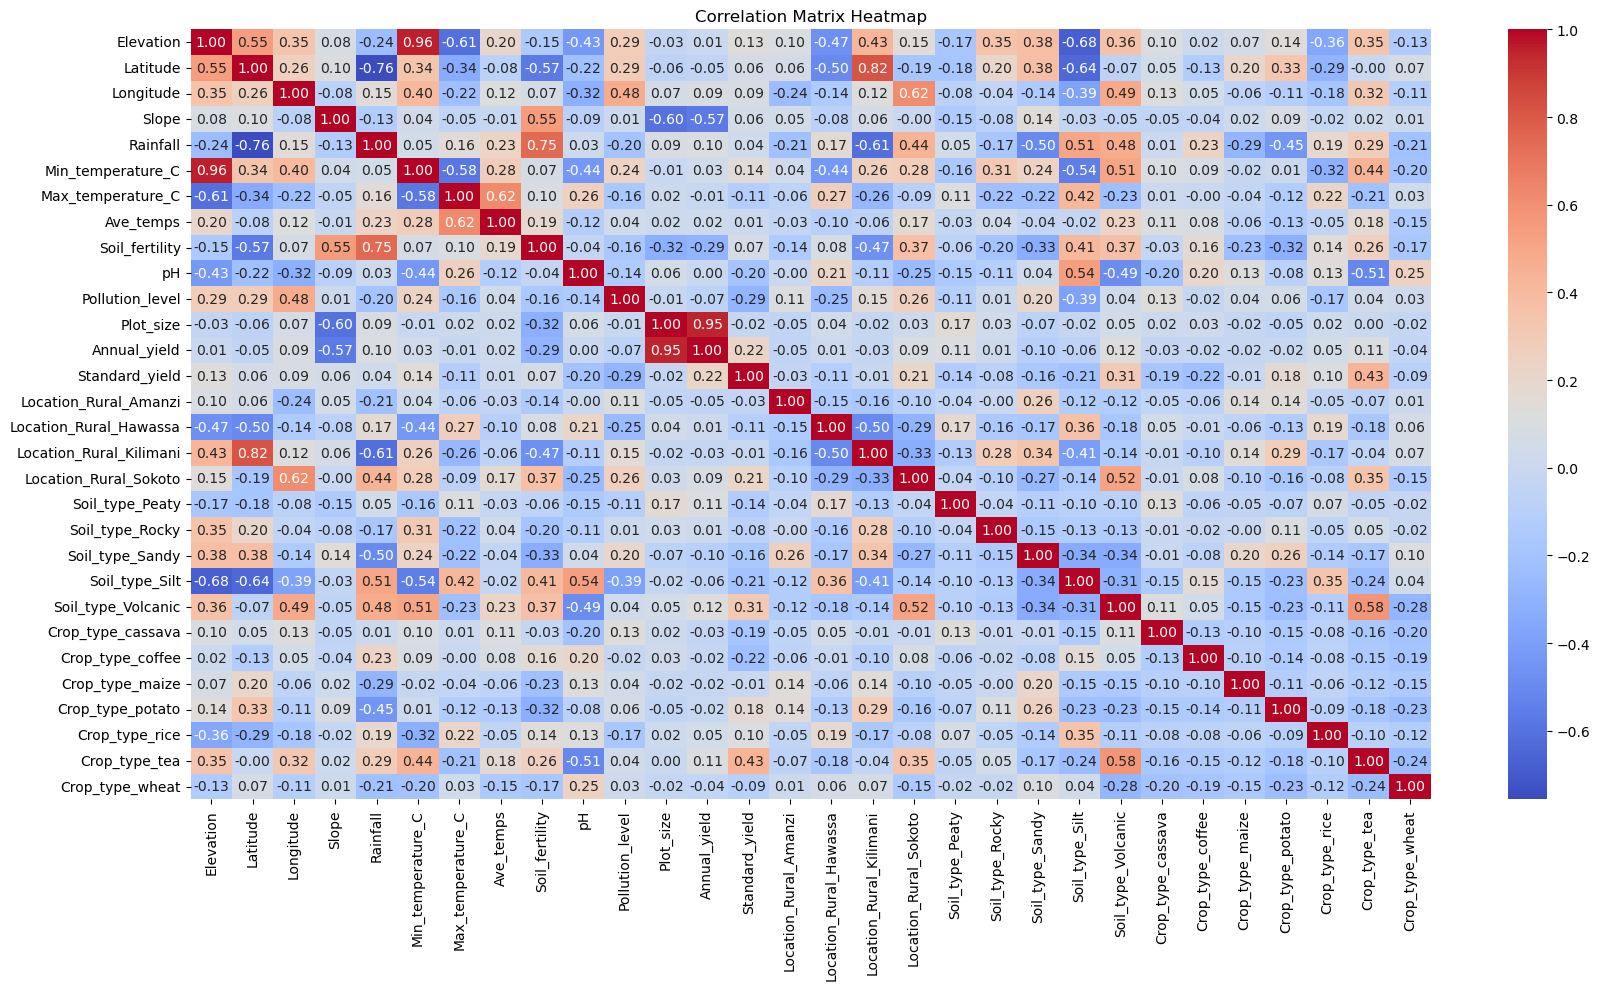

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt


correlation_matrix = dataset_dummies.corr()


plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()


Based on the correlation coefficients:
- Plot_size and Crop_type_tea have a very low correlation (close to zero), indicating weak correlation.
- Pollution_level and Soil_type_Rocky have a small positive correlation of 0.013, indicating a weak correlation.
- Crop_type_cassava and Soil_type_Sandy have a small negative correlation of -0.006, indicating a weak correlation.
- Min_temperature_C and Elevation have a strong positive correlation of 0.956, indicating a strong correlation.
- Therefore, the pair Min_temperature_C and Elevation have a strong correlation with each other.

### Question 7
Now that we have analysed our variables, let's fit an ordinary least squares regression model using `statsmodels.formula.api` and then print the model summary. Construct the model using all the independent variables in our encoded dataset (excuding `Field_ID`).<br>

Which of the following statements accurately describes the interpretation of the F-statistic in the context of our regression model?

#### Options
* The F-statistic tests the overall significance of the regression model. A low F-statistic value with a corresponding high p-value  indicates that the regression model is statistically significant, meaning that at least one of the independent variables has a significant effect on the dependent variable.
* The F-statistic tests the overall significance of the regression model. A high F-statistic value with a corresponding low p-value indicates that the regression model is statistically significant, meaning that at least one of the independent variables has a significant effect on the dependent variable.
* The F-statistic tests the overall significance of the regression model. A high F-statistic value with a corresponding high p-value indicates that the regression model is statistically significant, meaning that at least one of the independent variables has a significant effect on the dependent variable.
* The F-statistic tests the overall significance of the regression model. A low F-statistic value with a corresponding low p-value  indicates that the regression model is not statistically significant, meaning that none of the independent variables have a significant effect on the dependent variable.

In [14]:

formula = 'Standard_yield ~ ' + ' + '.join(dataset_dummies.drop(columns=['Standard_yield']).columns)

model = smf.ols(formula=formula, data=dataset_dummies).fit()

print(model.summary())



                            OLS Regression Results                            
Dep. Variable:         Standard_yield   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     623.8
Date:                Sat, 06 Apr 2024   Prob (F-statistic):               0.00
Time:                        11:28:55   Log-Likelihood:                 8358.2
No. Observations:                5654   AIC:                        -1.666e+04
Df Residuals:                    5625   BIC:                        -1.647e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

- The F-statistic in the context of a regression model tests the overall significance of the model by comparing the variance explained by the model to the variance not explained by the model. It essentially tests whether at least one of the independent variables has a non-zero coefficient, indicating that there is a linear relationship between the independent variables and the dependent variable.



***F-statistic: 623.8***

***Prob (F-statistic): 0.00 (or very close to 0)***


- The F-statistic is relatively high, indicating that the explained variance by the model is significantly greater than the unexplained variance. Additionally, the associated p-value (Prob (F-statistic)) is very close to 0, indicating strong evidence against the null hypothesis.


- The F-statistic tests the overall significance of the regression model. A high F-statistic value with a corresponding low p-value indicates that the regression model is statistically significant, meaning that at least one of the independent variables has a significant effect on the dependent variable.

### Question 8 

This summary  gives us an indication of possible multicollinearity present within our predictor variables. The presence of any correlation among predictors is detrimental to model quality because it tends to increase the standard error of the coefficients and it becomes difficult to estimate the effect of any one predictor variable on the response variable.

To avoid this, let's reduce the number of independent variables included in our model.
Fit the model using the following variables:<br>

* `Pollution_level` 
* `Crop_type_coffee` 
* `Crop_type_tea`
* `Location_Rural_Sokoto`
* `Annual_yield` 
* `Soil_type_Silt`
* `Soil_type_Volcanic`

After reducing the number of dependent variables accordingly, how did the model change?

#### Options:

* The model worsened.
* The model improved.
* The model remained unchanged.
* It cannot be determined from the given information.

In [15]:
import statsmodels.formula.api as smf


reduced_formula = ('Standard_yield ~ Pollution_level + Crop_type_coffee + Crop_type_tea + '
                   'Location_Rural_Sokoto + Annual_yield + Soil_type_Silt + Soil_type_Volcanic')

reduced_model = smf.ols(formula=reduced_formula, data=dataset_dummies).fit()


print(reduced_model.summary())


                            OLS Regression Results                            
Dep. Variable:         Standard_yield   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     552.1
Date:                Sat, 06 Apr 2024   Prob (F-statistic):               0.00
Time:                        11:29:06   Log-Likelihood:                 5839.8
No. Observations:                5654   AIC:                        -1.166e+04
Df Residuals:                    5646   BIC:                        -1.161e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.56

- R-squared: The R-squared value decreased from 0.756 to 0.406. R-squared measures the proportion of the variance in the dependent variable that is predictable from the independent variables. A higher R-squared value indicates a better fit of the model to the data. In this case, the decrease in R-squared suggests that the reduced model explains less variability in the dependent variable compared to the original model.

- F-statistic: The F-statistic decreased from 623.8 to 552.1. The F-statistic tests the overall significance of the regression model. A higher F-statistic value indicates a better overall fit of the model. The decrease in the F-statistic suggests that the reduced model's overall significance decreased compared to the original model.

- Adjusted R-squared: The adjusted R-squared value also decreased from 0.755 to 0.406. Adjusted R-squared takes into account the number of independent variables in the model and penalizes excessive complexity. Similar to R-squared, a higher adjusted R-squared value indicates a better fit of the model. The decrease in adjusted R-squared further confirms the reduced model's poorer performance compared to the original model.

- AIC and BIC: Both AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) increased in the reduced model compared to the original model. A lower AIC and BIC indicate a better model fit. The increase in both AIC and BIC suggests that the reduced model is less favorable in terms of goodness of fit and model complexity compared to the original model.

- -Based on these observations, we can conclude that:***The model worsened***. The reduction in the number of independent variables led to a decrease in the model's performance, as evidenced by lower R-squared, F-statistic, and adjusted R-squared values, as well as higher AIC and BIC values.

### Question 9
Let's evaluate our model's results. Generate a scatter plot of the residuals against the fitted values allowing us to visually inspect whether the residuals have constant variance and are distributed randomly around the zero residual line.

What does the scatter plot tell us?

#### Options

* The model has perfect predictive accuracy.
* The plot indicates homoscedasticity as residuals have a constant variance and are distributed randomly around the zero residual line.
* There is no linear relationship between the dependent and independent variables.
* The model suffers from multicollinearity.

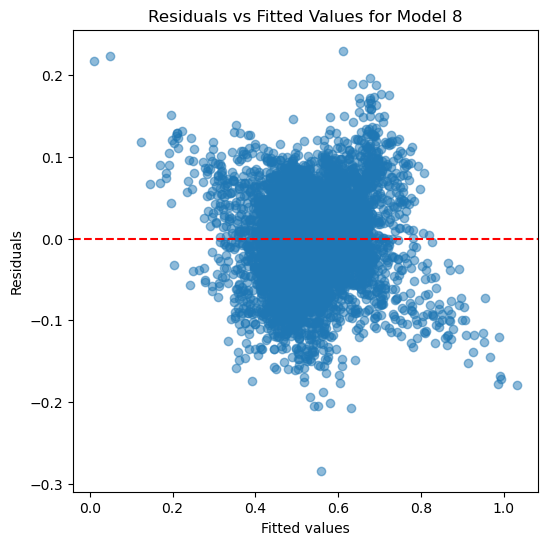

In [54]:
residuals_model8 = model.resid

# Calculate fitted values for model 8
fitted_values_model8 = model.fittedvalues

# Create scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(fitted_values_model8, residuals_model8, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values for Model 8')
plt.show()

2024-04-06 11:29:15,898 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


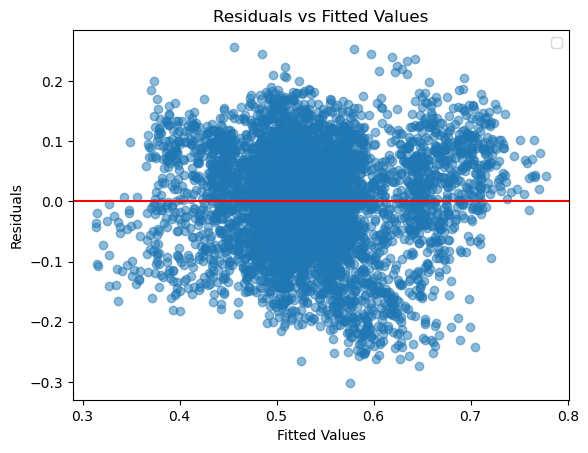

In [16]:
import matplotlib.pyplot as plt

residuals = reduced_model.resid

predicted_values = reduced_model.fittedvalues

plt.scatter(predicted_values, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')  
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.legend()
plt.show()



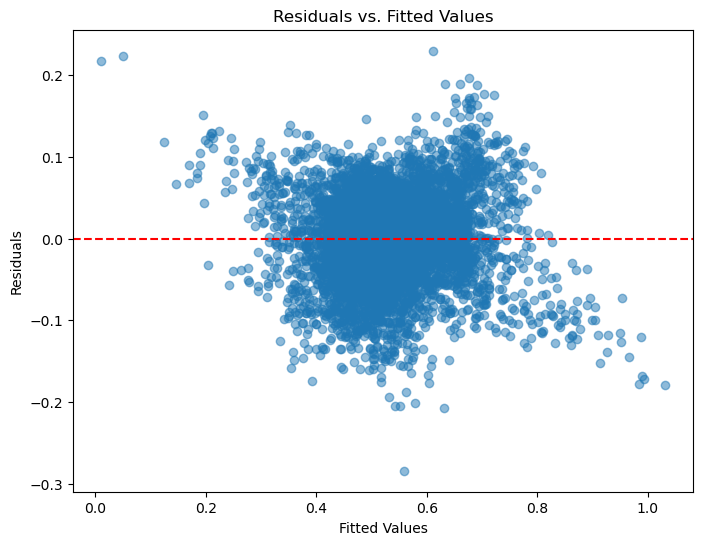

In [53]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Assuming 'X' is your independent variable DataFrame and 'y' is your dependent variable Series
X = dataset_dummies.drop('Standard_yield', axis=1)
y = dataset_dummies['Standard_yield']

# Add a constant term for the intercept
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Calculate predicted values (fitted values)
fitted_values = model.predict(X)

# Calculate residuals
residuals = y - fitted_values
# Calculate predicted values (fitted values)
fitted_values = model.predict(X)

# Calculate residuals
residuals = y - fitted_values

# Scatter plot of residuals against fitted values
plt.figure(figsize=(8, 6))
plt.scatter(fitted_values, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0 for reference
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

- The plot indicates homoscedasticity as residuals have a constant variance and are distributed randomly around the zero residual line.

### Question 10
If a linear regression model indicated heteroscedasticity, which of the following actions could be considered to address this issue?

* Applying transformations to the independent variables to better fit the linear relationship.
* Implementing weighted least squares regression to give less emphasis to observations with higher variance in residuals.
* Removing outliers from the dataset to reduce the impact of extreme values on the variance of residuals.
* All of the above.

- All of the above because 

- Applying transformations to the independent variables: Transforming the independent variables can help improve the linear relationship between the variables, which may lead to more homoscedastic residuals.

- Implementing weighted least squares regression: Weighted least squares regression assigns different weights to observations based on their variance, giving less emphasis to observations with higher variance in residuals. This can help mitigate the impact of heteroscedasticity.

- Removing outliers from the dataset: Outliers can contribute to heteroscedasticity by introducing extreme values that affect the variance of residuals. Removing outliers can reduce the influence of these extreme values on the variance of residuals, potentially leading to more homoscedastic residuals.

## Challenge 3: Using regularisation to optimise agricultural yield

Continuing with our task, after fitting our model, we decide to go back to the drawing board to explore more ways to implement feature engineering and data pre-processing in order to optimise our model. We suspect that, if we use all the variables available to us, the model might overfit due to the high dimensionality of the data. Regularisation techniques will therefore be critical in building a predictive model that generalises well to new, unseen data.

### Question 11
Our first step in the feature engineering involves creating a new feature, `Temperature_Range`, and scaling features using `StandardScaler`. The difference between `Min_temperature_C` and `Max_temperature_C` is the temperature range.

Given the code block below, which option correctly completes the feature engineering step of creating the `Temperature_Range` column?

**Hint**: Insert the correct code snippet into the appropriate location within the code block to run it.

#### Options:

* `dataset['Temperature_Range'] = dataset[['Min_temperature_C','Max_temperature_C']].min(axis=1)`
* `dataset['Temperature_Range'] = dataset['Max_temperature_C'] - dataset['Min_temperature_C']`
* `dataset = dataset.assign(Temperature_Range = dataset['Max_temperature'] - dataset['Min_temperature'])`
* `dataset[['Temperature_Range']] = dataset[['Max_temperature_C']] - dataset[['Min_temperature_C']]`



In [17]:

from sklearn.preprocessing import StandardScaler
dataset['Temperature_Range'] = dataset['Max_temperature_C'] - dataset['Min_temperature_C']


# Select features for scaling (exclude non-numeric or target variables)
features = ['Elevation', 'Slope', 'Rainfall', 'Ave_temps', 'Temperature_Range', 'Soil_fertility', 'pH', 'Pollution_level']

# Initialise StandardScaler and apply it to the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(dataset[features])

# Show the first 5 rows of the scaled features
print(scaled_features[:5])


[[ 0.85426539  0.31997088 -0.15356676  2.21747303  0.30626766  0.01544079
   0.71256827 -0.61634976]
 [ 0.21055364 -0.03858151  0.49777372  0.15900087 -0.25298298  0.4619994
   0.08816394  0.7886906 ]
 [ 1.08748981 -0.04224188  2.01496684  0.09662293 -1.66755812  1.57839593
  -0.34858051  0.60254524]
 [-0.3620941  -0.4856324  -1.74719984 -0.02813296  0.8984154  -1.77079366
  -0.35345077  0.28374058]
 [ 1.43215211  4.53523034 -0.83392242  1.28180387 -0.58195394  2.24823384
   0.14466333 -0.80437805]]


- dataset['Temperature_Range'] = dataset['Max_temperature_C'] - dataset['Min_temperature_C']

### Question 12


Consider a scenario where we decide to employ LASSO regression to identify predictive features associated with our dependent variable.

We implement the Python code block provided below.

What is the purpose of the `LassoCV(cv=5)` constructor parameter `cv=5`?

#### Options:

* It indicates that 5-fold cross-validation should be used to select the best regularisation parameter.
* It sets the penalty coefficient to 5, increasing the regularisation strength.
* It specifies that the LASSO model should use a 5-degree polynomial feature expansion.
* It defines that the model should only select 5 features at most.

In [18]:
from sklearn.linear_model import LassoCV

# scaled_features is our matrix of scaled features and dataset['Standard_yield'] is the target variable
lasso = LassoCV(cv=5).fit(scaled_features, dataset['Standard_yield'])

# Find the features with non-zero coefficients
selected_features = [features[i] for i, coef in enumerate(lasso.coef_) if coef != 0]

- The purpose of the cv=5 parameter in LassoCV(cv=5) constructor is:

- It indicates that 5-fold cross-validation should be used to select the best regularization parameter.



- cv=5 specifies that 5-fold cross-validation should be performed during the process of selecting the best regularization parameter (alpha) for the Lasso regression model.
- Cross-validation is a technique used to assess how well a model will generalize to an independent dataset by splitting the data into multiple subsets (folds), training the model on some of these subsets, and evaluating it on the remaining subset.
- In this context, 5-fold cross-validation means that the dataset will be divided into 5 equal parts, and the model will be trained and evaluated 5 times, each time using a different combination of training and validation sets.
- The LassoCV constructor will use this cross-validation process to determine the optimal alpha value, which controls the strength of regularization in Lasso regression.

### Question 13

In trying to address multicollinearity in our dataset, we also decide to implement Ridge regression. After understanding that Ridge regression applies an L2 penalty to the coefficients to reduce their magnitude without setting them to zero, we decide to use `RidgeCV` for applying Ridge regression with cross-validation to select the optimal penalty strength. Given the snippet of code below, which parameter correctly adjusts the strength of the regularisation applied to the model?

**Hint**: Insert the correct code snippet into the appropriate location within the code block to run it.

#### Options:
* `cv=[0.001, 0.01, 0.1, 1, 10, 100]`
* `fit_intercept=True`
* `alphas=[0.001, 0.01, 0.1, 1, 10, 100]`
* `scoring='neg_mean_squared_error`

In [19]:
from sklearn.linear_model import RidgeCV

# Insert selected option here
alphas = [0.001, 0.01, 0.1, 1, 10, 100]

# Apply Ridge regression with cross-validation
ridge = RidgeCV(alphas=alphas, cv=5).fit(scaled_features, dataset['Standard_yield'])

- alphas=[0.001, 0.01, 0.1, 1, 10, 100]

### Question 14

Given our dataset includes variables such as `Elevation` and `Slope`, and considering the potential interactions between these variables might impact crop yield, we aim to capture both these interactions and possible non-linear relationships. Which of the following methods is specifically designed to create a quadratic interaction term without including an intercept in the feature set?

**HINT:** Consider utilising `sklearn`'s feature transformation tools for this purpose.

* `poly = PolynomialFeatures(degree=2, include_bias=False)` 
* `poly = PolynomialFeatures(degree=1, include_bias=False)` 
* `poly = PolynomialFeatures(degree=3, include_bias=True)` 
* `poly = PolynomialFeatures(degree=2, include_bias=True)`

In [20]:
from sklearn.preprocessing import PolynomialFeatures

# Generate polynomial and interaction features
#Insert selected option here
poly = PolynomialFeatures(degree=2, include_bias=False)

poly_features = poly.fit_transform(dataset[['Elevation', 'Slope']])

# Display the shape of the new feature matrix
poly_features.shape


(5654, 5)

### Question 15

After implementing Ridge regression to address multicollinearity and prevent overfitting in our model we need to interpret the coefficients to understand the impact of each feature on the standard yield.

Based on the output of the Ridge regression coefficients in the code block below, which statement is true regarding the impact of each feature on the standard yield?

#### Options:

* Feature 1 has the highest positive impact, followed by Feature 2 and Feature 3.
* Feature 3 has the highest positive impact, followed by Feature 1 and Feature 2.
* The coefficients are inconclusive; further analysis is needed to determine the impact of each feature.
* Feature 2 has the highest positive impact, while Feature 3 and Feature 1 have negative impacts.

In [21]:
from sklearn.linear_model import Ridge
import numpy as np

# Assuming `X` is the feature matrix and `y` is the target variable
X = np.array([[0.5, 0.2, 0.1],
              [0.9, 0.3, 0.5],
              [0.3, 0.8, 0.2]])
y = np.array([0.7, 0.6, 0.8])

# Fit Ridge regression model with alpha = 0.1
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X, y)

# Display the coefficients of the model
ridge_model.coef_


array([-0.13661379,  0.10262221, -0.07348657])

- Feature 2 has the highest positive impact, while Feature 3 and Feature 1 have negative impacts.

## Challenge 4: Making a prediction using decision trees

After learning that decision trees are easy to implement and are capable of handling both categorical and numerical data while being resilient to outliers, we decide to implement a decision tree on our encoded dataset.

### Question 16
Train a decision tree with the following specifications:
* Using our **previously encoded dataset**, split the data into dependent and independent variables using all the features except for `Standard_yield` and `Field_ID` as independent variables.
* Split the data into training and testing data.
* Use the `DecisionTreeRegressor` to fit a model using a `max_depth' of 2 and a `random_state` of 42.

Using the trained Decision Tree Regressor model, make a prediction for `y` given the following x-values:<br> 
`[864.66138, -8.12890218821531, -8.311822719284072, 16.274624300000003, 1237.7200000000003, -3.4100000000000006, 36.410000000000004,`
`16.5,0.682, 6.7863323423108195, 0.09379352739936421, 1.4300000000000002, 0.8264890400277934,0.0,0.0,0.0,0.0,0.0,0.0,1.1,0.0,0.0,1.1,0.0, 0.0,0.0,0.0,0.0,0.0]`

What is the value of the predicted y?

#### Options
* 0.3250077
* 0.6654377
* 0.48494414
* 0.8050340

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

# Splitting the data into dependent and independent variables
X = dataset_dummies.drop(columns=['Standard_yield'])
y = dataset_dummies['Standard_yield']

# Get feature names
feature_names = X.columns

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fitting a Decision Tree Regressor model
dt_regressor = DecisionTreeRegressor(max_depth=2, random_state=42)
dt_regressor.fit(X_train, y_train)

# Making a prediction for the given x-values
x_values = [864.66138, -8.12890218821531, -8.311822719284072, 16.274624300000003, 1237.7200000000003, 
            -3.4100000000000006, 36.410000000000004, 16.5, 0.682, 6.7863323423108195, 0.09379352739936421, 
            1.4300000000000002, 0.8264890400277934, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1, 0.0, 0.0, 1.1, 
            0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
predicted_y = dt_regressor.predict([x_values])

print("Predicted y value:", predicted_y)



Predicted y value: [0.48494414]


C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


### Question 17

Based on the model above, what is the value of our RMSE?

* 0.0658
* 0.0881
* 0.5656
* 0.8810

In [25]:

from sklearn.metrics import mean_squared_error
# Making predictions on the test set
predicted_y_test = dt_regressor.predict(X_test)

# Calculating RMSE
rmse = np.sqrt(mean_squared_error(y_test, predicted_y_test))

# Rounding RMSE to four decimal places
rounded_rmse = round(rmse, 4)

# Displaying rounded RMSE
print("Root Mean Squared Error (RMSE):", rounded_rmse)


Root Mean Squared Error (RMSE): 0.0881


### Question 18
Which of the following statements is correct about our RMSE?

#### Options
* An RMSE of 0.0881 suggests that, on average, the predicted values are off by approximately 0.0881 units
* An RMSE value of 0.0881 suggests that, at most, the predicted values deviate by approximately 0.08 units from the actual values.
* An RMSE of 0.0881 indicates a perfect fit of the model to the training data.
* An RMSE of 0.0881 suggests that the predicted values are correct 8.81% of the time.

- An RMSE of 0.0881 suggests that, on average, the predicted values are off by approximately 0.0881 units.

- This statement accurately describes the interpretation of the RMSE, indicating the average deviation between the predicted values and the actual values.

### Question 19 
What is the likely effect of adjusting the `max_depth` parameter in a Decision Tree model?

#### Options

* Lower max_depth values may lead to increased model complexity and a higher risk of underfitting
* Higher max_depth values may lead to decreased model complexity and a lower risk of overfitting
* Higher max_depth values reduce the likelihood of capturing complex relationships in the data.
* Higher max_depth values may lead to increased model complexity and a higher risk of overfitting.


In [26]:


# Splitting the data into dependent and independent variables
X = dataset_dummies.drop(columns=['Standard_yield'])
y = dataset_dummies['Standard_yield']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Fitting a Decision Tree Regressor model with specified max_depth
dt_regressor = DecisionTreeRegressor(random_state=42)
dt_regressor.fit(X_train, y_train)

# Making predictions
y_pred = dt_regressor.predict(X_test)

# Calculating RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(rmse)


0.03461382900083047


In [27]:


# Splitting the data into dependent and independent variables
X = dataset_dummies.drop(columns=['Standard_yield'])
y = dataset_dummies['Standard_yield']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define max_depth value
max_depth_value = 7

# Fitting a Decision Tree Regressor model with specified max_depth
dt_regressor = DecisionTreeRegressor(max_depth=max_depth_value, random_state=42)
dt_regressor.fit(X_train, y_train)

# Making predictions
y_pred = dt_regressor.predict(X_test)

# Calculating RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"Max Depth: {max_depth_value}, RMSE: {rmse:.4f}")

Max Depth: 7, RMSE: 0.0548


### Question 20 
Let's attempt to enhance our model's performance by setting the `max_depth` hyperparameter to 5.

True or false? The decision tree model was improved by fitting it with a `max_depth` parameter of 5.

#### Options
* True
* False

In [28]:
from sklearn.metrics import mean_squared_error

# Splitting the data into dependent and independent variables
X = dataset_dummies.drop(columns=['Standard_yield'])
y = dataset_dummies['Standard_yield']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

max_depth_value = 5

# Fitting a Decision Tree Regressor model with specified max_depth
dt_regressor = DecisionTreeRegressor(max_depth = max_depth_value, random_state=42)
dt_regressor.fit(X_train, y_train)

# Making predictions
y_pred = dt_regressor.predict(X_test)

# Calculating RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Max Depth: {max_depth_value}, RMSE: {rmse:.4f}")



0.0881

Max Depth: 5, RMSE: 0.0633


- True

## Challenge 5: Ensemble Methods & Bootstrapping

Using our original dataset, our objective is to explore ensemble methods and bootstrapping techniques to enhance the model performance. We'll work with a subset of features from the dataset to predict the `Standard_yield`.

### Question 21 
Consider the following approach to implement a bootstrap aggregation (bagging) for predicting the `Standard_yield` based on features `Elevation`, `Slope`, `Soil_fertility`, and `Pollution_level`. Given are the steps and part of the Python code implementing this method. Our task is to identify the correct piece of code that completes the implementation.

The steps for the implementation are as follows:

1. Create an empty list named `predictions` to store predictions from each bootstrap sample.
2. Generate `n_bootstrap_samples` bootstrap samples from the original dataset.
3. For each bootstrap sample, fit a linear regression model and predict the `Standard_yield` on the entire dataset.
4. Store each set of predictions in the predictions list.
5. Average the predictions across all bootstrap samples to obtain the final bagged prediction.
6. Compute and print the mean squared error (MSE) to evaluate the performance of the bagged model.


Below is the code block with a missing part that needs to be completed:

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
import numpy as np

# X_train, y_train represent the features and target variable from the training data
X = dataset[['Elevation', 'Slope', 'Soil_fertility', 'Pollution_level']]
y = dataset['Standard_yield']

predictions = []
n_bootstrap_samples = 100

for _ in range(n_bootstrap_samples):
    X_sample, y_sample = resample(X, y)
    model = LinearRegression()
    model.fit(X_sample, y_sample)
    y_pred = model.predict(X)
    predictions.append(y_pred)

# MISSING PART HERE
# MISSING PART HERE
bagged_predictions = np.mean(predictions, axis=0)
mse_bagged = mean_squared_error(y, bagged_predictions)


print(f"Mean Squared Error of Bagged Linear Regression Models: {mse_bagged}")


Mean Squared Error of Bagged Linear Regression Models: 0.010840493965058656


In [55]:
predictions

[array([0.58134078, 0.5108068 , 0.54589138, ..., 0.57955279, 0.54233166,
        0.55111866]),
 array([0.58509292, 0.51239352, 0.54934692, ..., 0.58431165, 0.5433742 ,
        0.54924403]),
 array([0.58268538, 0.50598392, 0.54025077, ..., 0.57900656, 0.54302551,
        0.55470491]),
 array([0.58462268, 0.51005628, 0.55035729, ..., 0.58420823, 0.54489646,
        0.55432505]),
 array([0.58077659, 0.51164412, 0.54702599, ..., 0.57848987, 0.54303552,
        0.55484834]),
 array([0.58290959, 0.50726094, 0.54425439, ..., 0.57885776, 0.54092391,
        0.55624464]),
 array([0.58336352, 0.51375336, 0.55256143, ..., 0.58150638, 0.53966352,
        0.55107206]),
 array([0.58106751, 0.51252897, 0.55040998, ..., 0.57799853, 0.54173175,
        0.55846176]),
 array([0.57910555, 0.50971257, 0.54127163, ..., 0.57551167, 0.54194832,
        0.55337074]),
 array([0.58250848, 0.5129639 , 0.54723873, ..., 0.57799363, 0.54186537,
        0.55769423]),
 array([0.58097911, 0.51041238, 0.54209313, ..., 0

Which code should replace the # MISSING PART HERE section to correctly implement the averaging of predictions and computation of the mean squared error?

#### Options


* `bagged_prediction = np.average(predictions, axis=1)`

   `mse_bagged = mean_squared_error(y, bagged_prediction)`
<br><br>

* `bagged_prediction = np.median(predictions, axis=0)`

  `mse_bagged = mean_squared_error(y, bagged_prediction)`
<br><br>

* `bagged_prediction = np.mean(predictions, axis=0)`

   `mse_bagged = mean_squared_error(y, bagged_prediction)`
<br><br>

* `bagged_prediction = np.mean(predictions, axis=1)`

   `mse_bagged = mean_squared_error(y, bagged_prediction)` 

### Question 22 

Given the following code snippet that applies a `RandomForestRegressor` to a dataset, which parameter in the `RandomForestRegressor` constructor is crucial for implementing the random subspace method by allowing the algorithm to select a random subset of features for each split?

#### Options
* `max_depth`
* `random_state`
* `max_features`
* `n_estimators`

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Initialise and train the random forest model
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X, y)

# Predict using the random forest model
y_pred_rf = rf_model.predict(X)

# Evaluate the model
mse_rf = mean_squared_error(y, y_pred_rf)
print(f"Mean Squared Error of Random Forest Regressor: {mse_rf}")


Mean Squared Error of Random Forest Regressor: 0.0011007529232950352


- The max_features parameter in RandomForestRegressor controls the number of features to consider when looking for the best split at each node. 
- By setting max_features to a value less than the total number of features, the algorithm randomly selects a subset of features to consider for splitting at each node. This is a key aspect of the random subspace method, which introduces randomness into the feature selection process, making each tree in the random forest model different.

### Question 23

### Question 23 (Medium)

Consider the theoretical setup for a stacking ensemble model designed for a regression task. The first layer of this model includes three different types of regression models: linear regression, ridge regression, and a support vector machine (SVM) with a linear kernel. The second layer, or the final estimator, uses a linear regression model to combine the predictions from the first layer. The goal is to theoretically predict `Standard_yield` based on features such as `Elevation`, `Slope`, `Soil_fertility`, and `Pollution_level`, with the intention to evaluate the model's hypothetical performance using the Mean Squared Error (MSE).

Given the following theoretical code snippet that outlines this stacking ensemble model's setup, what should replace the `_____` in the code to correctly configure the SVM with a linear kernel as part of the base learners in the stacking model?

#### Options
* `linear`
* `lin`
* `sigmoid`
* `degree=1`

In [31]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error

# Define base learners
estimators = [
    ('lr', LinearRegression()),
    ('ridge', Ridge()),
    ('svr', SVR(kernel= 'linear'))
]

# Define the theoretical stacking model
stacking_model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
stacking_model

# Note: Assume X, y represent the features and target variable respectively, for a theoretical prediction scenario.

StackingRegressor(estimators=[('lr', LinearRegression()), ('ridge', Ridge()),
                              ('svr', SVR(kernel='linear'))],
                  final_estimator=LinearRegression())

- When configuring the SVM (SVR) with a linear kernel, we specify kernel='linear'.
- The linear option corresponds to a linear kernel, which implies that the SVM model will use a linear kernel function for its operation. This kernel computes the dot product between the input samples, effectively implementing a linear transformation of the input data.


### Question 24

Consider the following Python code snippet that aims to implement a 5-fold cross-validation scheme to estimate the accuracy of a ridge regression model. This model uses bootstrapped samples within each fold to predict `Standard_yield` and calculates the average Mean Squared Error (MSE) across all folds.

Which of the following options correctly fill in the blanks to ensure the code correctly implements the described functionality?

#### Options
* `scoring='r2'`, `cv=10`
* `scoring='mean_absolute_error'`, `cv=5`
* `scoring='neg_mean_squared_error'`, `cv=5`
* `scoring='neg_mean_squared_error'`, `cv='Bootstrap'`


In [32]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
import numpy as np

# Initialise the ridge regression model
ridge_model = Ridge()

# Perform 5-fold cross-validation with bootstrapping
scores = cross_val_score(ridge_model, X, y, scoring='neg_mean_squared_error', cv=5) #add correct option here 

# Convert scores to positive MSE
mse_scores = -scores

# Calculate average MSE
average_mse = np.mean(mse_scores)
print(f"Average Mean Squared Error from Cross-Validation: {average_mse}")

Average Mean Squared Error from Cross-Validation: 0.010875483717316465


- We want to estimate the accuracy of a ridge regression model using a 5-fold cross-validation scheme.
- Since we are interested in Mean Squared Error (MSE), we need to use the negative MSE as the scoring metric. This is because scikit-learn's convention for scoring is to maximize scores, but MSE is typically minimized. Therefore, we use the neg_mean_squared_error scorer.


### Question 25

Consider the code snippet that extracts and prints the feature importances from a trained random forest regressor model. The model is used to predict `Standard_yield` based on various features. The code utilises the `feature_importances_` attribute of the random forest model to obtain importance scores for each feature.

Which of the following statements best describes the purpose and outcome of the provided code snippet?

#### Options

* The code identifies and prints the importance scores for each feature in the random forest model, indicating how much each feature contributes to the model's ability to predict `Standard_yield`. Higher scores suggest a greater contribution to the prediction.

* The code counts the number of times each feature is used to split the data across all trees in the random forest, thereby determining each feature's importance in predicting `Standard_yield`.

* The code calculates and prints the coefficient values for each feature used in the  random forest, model to predict `Standard_yield`, indicating the strength and direction of the relationship between each feature and the target variable.

* The code computes the correlation between each feature and the target variable `Standard_yield`, printing a list of features sorted by their correlation coefficients to identify the most relevant predictors.

In [33]:
# Extract feature importances
feature_importances = rf_model.feature_importances_

# Print feature importances
for feature, importance in zip(X.columns, feature_importances):
    print(f"Feature: {feature}, Importance: {importance}")

Feature: Elevation, Importance: 0.32014871052459914
Feature: Slope, Importance: 0.2189073558718058
Feature: Soil_fertility, Importance: 0.1537858903685721
Feature: Pollution_level, Importance: 0.307158043235023


- The code snippet extracts the feature importances from a trained random forest regressor model using the feature_importances_ attribute.
- It then iterates over each feature and its corresponding importance score, printing them out.
- The importance scores indicate the relative contribution of each feature to the model's prediction of the target variable Standard_yield.
- Higher importance scores imply that the corresponding feature plays a more significant role in predicting Standard_yield

***The code identifies and prints the importance scores for each feature in the random forest model, indicating how much each feature contributes to the model's ability to predict Standard_yield. Higher scores suggest a greater contribution to the prediction.***

## Challenge 6: Random forests
In this challenge, we want to test how our data fits to a random forest model and other functionalities that come with its such as analysing feature importance.

We are required to write a function named `train_rf_model` that trains and tests a random forest model on a given dataset. Our function should do the following:

* Take a `RandomForestRegressor` object (with any desired hyperparameters set) as input,
* Separate the features `X` and target `y` dataframes
* Split the data into training and testing sets - use a test size of `20%` and a random state of `42` for reproducibility
* Fit the model to the training data
* Make predictions on the testing set
* Return the trained model, the R-squared score, and the Mean Squared Error (MSE) of the test set predictions.

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = dataset_dummies.drop(columns=['Standard_yield'])
y = dataset_dummies['Standard_yield']


def train_rf_model(model, X, y):
    # Splitting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Fitting the model to the training data
    model.fit(X_train, y_train)
    
    # Making predictions on the testing set
    y_pred = model.predict(X_test)
    
    # Calculating R-squared score
    r2 = r2_score(y_test, y_pred)
    
    # Calculating Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_pred)
    
    return model, r2, mse


### Question 26
1) Implement the function outlined above.

2) Using the function, train a random forest model on our dataset with random_state set to 42, and max_depth=15, while leaving all other hyperparameters at their defaults. Use all the features available in the encoded dataset for this task. What are the R-squared and MSE scores for the model on the test data?

#### Options

* R2: 0.0059, MSE: 0.6198
* R2: 0.5555, MSE: 0.2345
* R2: 0.9586, MSE: 0.0006
* R2: 0.8196, MSE: 0.0500

In [36]:
# Assuming X and y are the feature and target dataframes respectively
model = RandomForestRegressor(random_state=42, max_depth=15)
trained_model, r2, mse = train_rf_model(model, X, y)

print("R-squared score:", r2)
print("Mean Squared Error:", mse)

R-squared score: 0.958985544262812
Mean Squared Error: 0.0005465351029774748


### Question 27

We want to examine how our data will fit to a random forest model when we tune the number of trees. We want to train and compare two random forest models with the same dataset as in the previous exercise. The first model should be trained with `150` trees, and the second model with `200` trees. Both models should use the default hyperparameters for all other settings, apart from a random_state of `42` to ensure reproducibility. After evaluating both models on the test set, how does the error differ between the two models?

#### Options

* The error increased when the number of trees was increased from 150 to 200.
* The model with 200 trees showed a significant decrease in error compared to the model with 150 trees.
* The model with 200 trees showed a very slight decrease in error compared to the model with 150 trees.
* There was no change in the error.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Train the first model with 150 trees
model_150_trees = RandomForestRegressor(n_estimators=150, random_state=42)
model_150_trees.fit(X_train, y_train)
y_pred_150_trees = model_150_trees.predict(X_test)
mse_150_trees = mean_squared_error(y_test, y_pred_150_trees)

# Train the second model with 200 trees
model_200_trees = RandomForestRegressor(n_estimators=200, random_state=42)
model_200_trees.fit(X_train, y_train)
y_pred_200_trees = model_200_trees.predict(X_test)
mse_200_trees = mean_squared_error(y_test, y_pred_200_trees)

# Train the first model with 150 trees
model_500_trees = RandomForestRegressor(n_estimators=500, random_state=42)
model_500_trees.fit(X_train, y_train)
y_pred_500_trees = model_500_trees.predict(X_test)
mse_500_trees = mean_squared_error(y_test, y_pred_500_trees)


model_600_trees = RandomForestRegressor(n_estimators=600, random_state=42)
model_600_trees.fit(X_train, y_train)
y_pred_600_trees = model_600_trees.predict(X_test)
mse_600_trees = mean_squared_error(y_test, y_pred_600_trees)

print("Mean Squared Error (150 trees):", mse_150_trees)
print("Mean Squared Error (200 trees):", mse_200_trees)
print("Mean Squared Error (500 trees):", mse_500_trees)
print("Mean Squared Error (600 trees):", mse_600_trees)


# Compare errors
if mse_150_trees < mse_200_trees:
    print("The model with 150 trees showed a lower error compared to the model with 200 trees.")
elif mse_150_trees > mse_200_trees:
    print("The model with 200 trees showed a lower error compared to the model with 150 trees.")
else:
    print("The errors are equal for both models.")


- The model with 200 trees showed a very slight decrease in error compared to the model with 150 trees."

### Question 28
Which of the following is a possible effect of increasing the number of trees in a random forest regression model?

#### Options
* Increasing the number of trees increases the model’s predictive ability up to a certain point, after which additional trees do not significantly impact performance.
* Increasing the number of trees always improves the model's predictive ability
* Increasing the number of trees significantly decreases the model's predictive ability
* The number of trees in a random forest model has no impact on the model's predictive ability.

- Increasing the number of trees increases the model’s predictive ability up to a certain point, after which additional trees do not significantly impact performance.

- This is because adding more trees can improve the robustness and stability of the model, leading to better generalization to unseen data. However, after a certain point, adding more trees may not provide significant additional benefits and may even lead to overfitting or increased computational complexity without substantial improvement in predictive performance.

### Question 29

Following the training of our random forest models, we decide to analyse the feature importance scores provided by the model built using 200 trees. Our aim is to identify which features the model considers most significant in predicting the target variable.

Which of the following does the model consider to be the top 3 most significant features in predicting Standard_yield?

#### Options

* Soil_fertility, Rainfall, Slope
* Rainfall, Crop_type_tea, Latitude
* pH, Rainfall, Location_Rural_Hawassa
* Elevation, Soil_fertility, pH

In [40]:
X.columns

Index(['Elevation', 'Latitude', 'Longitude', 'Slope', 'Rainfall',
       'Min_temperature_C', 'Max_temperature_C', 'Ave_temps', 'Soil_fertility',
       'pH', 'Pollution_level', 'Plot_size', 'Annual_yield',
       'Location_Rural_Amanzi', 'Location_Rural_Hawassa',
       'Location_Rural_Kilimani', 'Location_Rural_Sokoto', 'Soil_type_Peaty',
       'Soil_type_Rocky', 'Soil_type_Sandy', 'Soil_type_Silt',
       'Soil_type_Volcanic', 'Crop_type_cassava', 'Crop_type_coffee',
       'Crop_type_maize', 'Crop_type_potato', 'Crop_type_rice',
       'Crop_type_tea', 'Crop_type_wheat'],
      dtype='object')

In [41]:

feature_importances_200_trees = model_200_trees.feature_importances_

feature_importance_dict = dict(zip(X.columns, feature_importances_200_trees))

sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

top_3_features = sorted_feature_importances[:3]
print("Top 3 most significant features:")
for feature, importance in top_3_features:
    print(feature)


Top 3 most significant features:
Rainfall
Crop_type_tea
Latitude


### Question 30
Which of the following initialised random forest models will allow access and calculation of the Out-of-Bag (OOB) score for performance evaluation without requiring a separate validation set?

#### Options
* RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=2, random_state=42)
* RandomForestRegressor(n_estimators=150, max_depth=None, oob_score=True)
* RandomForestRegressor(n_estimators=200, max_depth=5, min_samples_leaf=4, oob_score=False)
* RandomForestRegressor(n_estimators=120, max_features='sqrt', min_samples_leaf=2)

- In RandomForestRegressor, setting the parameter oob_score to True enables the calculation of the Out-of-Bag (OOB) score for performance evaluation.
- Out-of-Bag (OOB) score is an estimate of the model's performance on unseen data. It is calculated using the samples not included in the bootstrap sample used to train each individual tree in the random forest.
- By enabling oob_score, we can evaluate the model's performance without the need for a separate validation set, making it a convenient and efficient method for performance estimation.

***RandomForestRegressor(n_estimators=150, max_depth=None, oob_score=True)***

#  

<div align="center" style=" font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/ExploreAI_logos/EAI_Blue_Dark.png"  style="width:200px";/>
</div>